## Notebook to create a regional baseline model using an LSTM network

**Description**

The following notebook contains the code to create, train, validate and test a rainfall-runoff model using a LSTM 
network architecture. 
The code's logic is heavily based on [Hy2DL](https://github.com/KIT-HYD/Hy2DL) and [Neural Hydrology](https://doi.org/10.21105/joss.04050)[1].

**Inverse Model**

We create a inverse model for the backward problem. The model uses the [Caravan GRDC extension](10.5281/zenodo.10074416). Here we run some experiments to see the value of adding discharge information for inferring precipitation patterns over Germany.

**Authors**

Ashish Manoj J (ashish.manoj@kit.edu)

In [1]:
#Import necessary packages
import sys
import os
import pandas as pd
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from typing import Optional
import torch.nn.functional as F

from typing import List, Dict
from itertools import groupby

sys.path.append("../aux_functions") # Here give the location of the aux_functions folder
from functions_datasets import CARAVAN as DataBase # define what you import as DataBase! Also ensure that all the required Caravan datasets are downloaded and stored in a single folder!
from functions_datasets import validate_samples 
from functions_training import nse_basin_averaged
from functions_evaluation import rmse, nse
from functions_aux import create_folder, set_random_seed, write_report

Part 1. Initialize information

In [2]:
# paths to access the information
path_entities = '../data/combined_europe.txt'
path_data = '/pfs/data5/home/kit/iwu/as2023/dataset/01_europe_flood/Caravan/' # Caution! using absolute path here as I do not want to save the data together with the code

# dynamic forcings and target
dynamic_input = ['temperature_2m_mean','surface_net_solar_radiation_mean',
                 'surface_net_thermal_radiation_mean','qobs_lead'] 
target = ['total_precipitation_sum']

# static attributes that will be used
static_input = ['area', 'p_mean','ele_mt_sav','frac_snow','pet_mm_syr']

# time periods
training_period = ['1980-10-01','2005-09-30']
validation_period = ['2000-01-01','2005-12-31']

model_hyper_parameters = {
    "input_size": len(dynamic_input) + len(static_input),
    "no_of_layers":1,  
    "seq_length": 365,
    "hidden_size": 64,
    "batch_size":256,
    "no_of_epochs": 5,             
    "drop_out": 0.4, 
    "learning_rate": 0.001,
    "adapt_learning_rate_epoch": 10,
    "adapt_gamma_learning_rate": 0.5,
    "set_forget_gate":3
}

# define random seed
seed = 42
# Name of the folder where the results will be stored 
path_save_folder = '../results/with_discharge_R1'

# colorblind friendly palette for plotting
color_palette = {'observed': '#1f78b4','LSTM': '#ff7f00'}

In [3]:
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

Number of GPUs available: 1


In [4]:
# Create folder to store the results
create_folder(folder_path=path_save_folder)

Folder '../results/with_discharge_R1' already exists.


Part 2. Class to create the dataset object used to manage the information

In [5]:
class BaseDataset(Dataset):
    """Base data set class to load and preprocess data.

    Parameters
    ----------
    dynamic_inputs : List[str]
        name of variables used as dynamic series input in the lstm
    static_inputs : List[str]
        static inputs used as input in the lstm (e.g. catchment attributes)
    target: List[str]
        target variable(s)
    sequence_length: int
        sequence length used in the LSTM
    time_period: List[str]
        initial and final date (e.g. ['1987-10-01','1999-09-30']) of the time period of interest 
    path_entities: str
        path to a txt file that contain the id of the entities (e.g. catchment`s ids) that will be analyzed
    path_data: str
        path to the folder were the data is stored
    path_addional features: str
        Optional parameter. Allows the option to add any arbitrary data that is not included in the standard data sets.
        Path to a pickle file (or list of paths for multiple files), containing a dictionary with each key corresponding 
        to one basin id and the value is a date-time indexed pandas DataFrame.      
    forcing: List[str]
        For CAMELS-US dataset we should specificy which forcing data will be used (e.g. daymet, maurer, ndlas, etc.)
    check_Nan: bool
        Boolean that indicate if one should check of NaN values while processing the data
    """

    #Function to initialize the data
    def __init__(self, 
                 dynamic_input: List[str],
                 static_input: List[str],
                 target: List[str], 
                 sequence_length: int,
                 time_period: List[str],
                 path_entities: str,
                 path_data: str,
                 path_additional_features: str = '',
                 forcings: List[str] = None,
                 check_NaN:bool = True
                 ):

        # read and create variables
        self.time_period = time_period # time period that is being considered
        self.dynamic_input= dynamic_input  # dynamic forcings going as inputs of in the lstm
        self.target = target  # target variable
        self.sequence_length = sequence_length # sequence length

        entities_ids = np.loadtxt(path_entities, dtype='str').tolist() 
        # save the cathments as a list even if there is just one
        self.entities_ids = [entities_ids] if isinstance(entities_ids, str) else entities_ids # catchments

        self.sequence_data = {} # store information that will be used to run the lstm
        self.df_ts = {} # store processed dataframes for all basins
        self.scaler = {} # information to standardize the data 
        self.basin_std = {} # std of the target variable of each basin (can be used later in the loss function)
        self.valid_entities= [] # list of the elements that meet the criteria to be used by the lstm

        # process the attributes
        self.static_input = static_input # static attributes going as inputs to the lstm
        if static_input:
            self.df_attributes = self._load_attributes(path_data)

        # process additional features that will be included in the inputs (optional) ---
        if path_additional_features:
            self.additional_features = self._load_additional_features(path_additional_features)
        
        # This loop goes through all the catchments. For each catchment in creates an entry in the dictionary
        # self.sequence_data, where we will store the information that will be sent to the lstm
        for id in self.entities_ids:
            # load time series for specific catchment id
            df_ts = self._load_data(path_data=path_data, catch_id=id)
            # add additional features (optional)
            if path_additional_features:
                df_ts = pd.concat([df_ts, self.additional_features[id]], axis=1)
            
            # Defines the start date considering the offset due to sequence length. We want that, if possible, the start
            # date is the first date of prediction.
            start_date = pd.to_datetime(self.time_period[0],format="%Y-%m-%d")
            end_date = pd.to_datetime(self.time_period[1],format="%Y-%m-%d")
            freq = pd.infer_freq(df_ts.index)
            warmup_start_date = start_date - (self.sequence_length-1)*pd.tseries.frequencies.to_offset(freq)
            # filter dataframe for the period and variables of interest
            df_ts = df_ts.loc[warmup_start_date:end_date, self.dynamic_input + self.target]
            
            # reindex the dataframe to assure continuos data between the start and end date of the time period. Missing 
            # data will be filled with NaN, so this will be taken care of later. 
            full_range = pd.date_range(start=warmup_start_date, end=end_date, freq=freq)
            df_ts = df_ts.reindex(full_range)
            
            # checks for invalid samples due to NaN or insufficient sequence length
            flag = validate_samples(x = df_ts.loc[:, self.dynamic_input].values, 
                                    y = df_ts.loc[:, self.target].values, 
                                    attributes = self.df_attributes.loc[id].values if static_input else None, 
                                    seq_length = self.sequence_length,
                                    check_NaN = check_NaN
                                    )
            
            # create a list that contain the indexes (basin, day) of the valid samples
            valid_samples = np.argwhere(flag == 1)
            self.valid_entities.extend([(id, int(f[0])) for f in valid_samples])
            
            # only store data if this basin has at least one valid sample in the given period
            if valid_samples.size>0:
                self.df_ts[id] = df_ts
                
                # create dictionary entry for the basin
                self.sequence_data[id] = {}

                # store the information of the basin in a nested dictionary
                self.sequence_data[id]['x_d'] = torch.tensor(df_ts.loc[:, self.dynamic_input].values, dtype=torch.float32)
                self.sequence_data[id]['y'] = torch.tensor(df_ts.loc[:, self.target].values, dtype=torch.float32)
                if self.static_input:
                    self.sequence_data[id]['x_s'] = torch.tensor(self.df_attributes.loc[id].values, dtype=torch.float32)
                    
    def __len__(self):
        return len(self.valid_entities)
    
    def __getitem__(self, id):
        """This function is used by PyTorch's dataloader to extract the information"""
        basin, i = self.valid_entities[id]

        # tensor of inputs
        x_LSTM = self.sequence_data[basin]['x_d'][i-self.sequence_length+1:i+1, :]
        if self.static_input:
            x_s = self.sequence_data[basin]['x_s'].repeat(x_LSTM.shape[0],1)
            x_LSTM = torch.cat([x_LSTM, x_s], dim=1)
        
        # Ttensor of outputs
        y_obs = self.sequence_data[basin]['y'][i]

        # optional also return the basin_std
        if self.basin_std:
            return x_LSTM, y_obs, self.basin_std[basin].unsqueeze(0)
        else:
            return x_LSTM, y_obs

    def _load_attributes(self, path_data: str) -> pd.DataFrame:
        """Call the specific function that reads the static attributes information.
        
        Parameters
        ----------
        path_data : str
            path to the folder were the data is stored
            
        Returns
        -------
        df_attributes: pd.DataFrame
            Dataframe containing the attributes of interest for the catchments of interest
        """
        df_attributes = DataBase.read_attributes(path_data=path_data)
        df_attributes = df_attributes.loc[self.entities_ids, self.static_input]
        return df_attributes

    def _load_data(self, path_data: str, catch_id:str) -> pd.DataFrame:
        """Call the specific function that reads a specific catchment timeseries into a dataframe.

        Parameters
        ----------
        path_data : str
            path to the folder were the data is stored.
        catch_id : str
            basin_id.
        forcings : str
            Can be e.g. 'daymet' or 'nldas', etc. Must match the folder names in the 'basin_mean_forcing' directory. 

        Returns
        -------
        df: pd.DataFrame
            Dataframe with the catchments` timeseries
        """
        df_ts = DataBase.read_data(path_data=path_data, catch_id=catch_id)
        return df_ts

    def _load_additional_features(self, path_additional_features: str) -> Dict[str, pd.DataFrame]:
        """Read pickle dictionary containing additional features.

        Parameters
        ----------
        path_additional_features : str
            Path to a pickle file (or list of paths for multiple files), containing a dictionary with each key 
            corresponding to one basin id and the value is a date-time indexed pandas DataFrame.   

        Returns
        -------
        additional_features: Dict[str, pd.DataFrame]
            Dictionary where each key is a basin and each value is a date-time indexed pandas DataFrame with the 
            additional features
        """
        
        with open(path_additional_features, "rb") as file:
            additional_features = pickle.load(file)
        return additional_features
  
    def calculate_basin_std(self):
        """Fill the self.basin_std dictionary with the standard deviation of the target variables for each basin"""
        for id, data in self.sequence_data.items():
            self.basin_std[id] = torch.tensor(np.nanstd(data['y'].numpy()), dtype=torch.float32)
    
    def calculate_global_statistics(self,path_save_scaler:Optional[str] = ''):
        """Fill the self.scalar dictionary 
        
        The function calculates the global mean and standard deviation of the dynamic inputs, target variables and 
        static attributes, and store the in a dictionary. It will be used later to standardize used in the LSTM. This
        function should be called only in training period. 
        """
        global_x = np.vstack([df.loc[:, self.dynamic_input].values for df in self.df_ts.values()])
        self.scaler['x_d_mean'] = torch.tensor(np.nanmean(global_x, axis=0), dtype=torch.float32)
        self.scaler['x_d_std'] = torch.tensor(np.nanstd(global_x, axis=0), dtype=torch.float32)
        del global_x

        global_y = np.vstack([df.loc[:, self.target].values for df in self.df_ts.values()])
        self.scaler['y_mean'] = torch.tensor(np.nanmean(global_y, axis=0), dtype=torch.float32)
        self.scaler['y_std'] = torch.tensor(np.nanstd(global_y, axis=0), dtype=torch.float32)
        del global_y

        if self.static_input:
            self.scaler['x_s_mean'] = torch.tensor(self.df_attributes.mean().values, dtype= torch.float32)
            self.scaler['x_s_std'] = torch.tensor(self.df_attributes.std().values, dtype= torch.float32)

        if path_save_scaler: #save the results in a pickle file
            with open(path_save_scaler+'/scaler.pickle', 'wb') as f:
                pickle.dump(self.scaler, f)

    
    def standardize_data(self, standardize_output:bool=True):
        """Standardize the data used in the LSTM. 

        The function standardize the data contained in the self.sequence_data dictionary 
        
        Parameters
        ----------
        standardize_output : bool
            Boolean to define if the output should be standardize or not. 
        """
        for basin in self.sequence_data.values():
            # Standardize input
            basin['x_d'] = (basin['x_d'] - self.scaler['x_d_mean']) / self.scaler['x_d_std']
            if self.static_input:
                basin['x_s'] = (basin['x_s'] - self.scaler['x_s_mean']) / self.scaler['x_s_std']
            # Standardize output
            if standardize_output:
                basin['y'] = (basin['y'] - self.scaler['y_mean']) / self.scaler['y_std']

Part 3. Create the different datasets

In [10]:
# Dataset training
training_dataset = BaseDataset(dynamic_input=dynamic_input,
                               static_input=static_input,
                               target=target,
                               sequence_length=model_hyper_parameters['seq_length'],
                               time_period=training_period,
                               path_entities=path_entities,
                               path_data=path_data,
                               check_NaN=True)

training_dataset.calculate_basin_std()
training_dataset.calculate_global_statistics(path_save_scaler=path_save_folder) # the global statistics are calculated in the training period!
training_dataset.standardize_data()

In [11]:
# Dataset validation
validation_dataset = BaseDataset(dynamic_input=dynamic_input,
                                 static_input=static_input,
                                 target=target,
                                 sequence_length=model_hyper_parameters['seq_length'],
                                 time_period=validation_period,
                                 path_entities=path_entities,
                                 path_data=path_data,
                                 check_NaN=False)

validation_dataset.scaler = training_dataset.scaler # read the global statisctics calculated in the training period
validation_dataset.standardize_data(standardize_output=False)

Part 4. Create the different dataloaders

In [12]:
# DataLoader for training data.
train_loader = DataLoader(training_dataset, 
                          batch_size=model_hyper_parameters['batch_size'],
                          shuffle=True,
                          drop_last = True)

print('Batches in training: ', len(train_loader))
x_lstm, y, per_basin_target_std = next(iter(train_loader))
print(f'x_lstm: {x_lstm.shape} | y: {y.shape} | per_basin_target_std: {per_basin_target_std.shape}')

Batches in training:  53491
x_lstm: torch.Size([256, 365, 9]) | y: torch.Size([256, 1]) | per_basin_target_std: torch.Size([256, 1])


In [13]:
# DataLoader for validation data.
validation_batches=[[index for index, _ in group] for _ , group in groupby(enumerate(validation_dataset.valid_entities), 
                                                                           lambda x: x[1][0])] # each basin is one batch

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_sampler=validation_batches)

# see if the batches are loaded correctly
print('Batches in validation: ', len(validation_loader))
x_lstm, y= next(iter(validation_loader))
print(f'x_lstm: {x_lstm.shape} | y: {y.shape}')

# create some lists with the valid basins and the valid entities per basin that will help later to organize the data
valid_basins = [next(group)[0] for key, group in groupby(validation_dataset.valid_entities, key=lambda x: x[0])]
valid_entity_per_basin = [[id for _, id in group] for key, group in groupby(validation_dataset.valid_entities, 
                                                                            key=lambda x: x[0])]

Batches in validation:  1804
x_lstm: torch.Size([2192, 365, 9]) | y: torch.Size([2192, 1])


Part 5. Define LSTM class

In [6]:
# Define device (this will use all available GPUs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Cuda_LSTM(nn.Module):
    def __init__(self, model_hyper_parameters):
        super().__init__()
        self.num_features = model_hyper_parameters['input_size']
        self.hidden_units = model_hyper_parameters['hidden_size']
        self.num_layers = model_hyper_parameters['no_of_layers']

        self.lstm = nn.LSTM(input_size = model_hyper_parameters['input_size'], 
                            hidden_size = model_hyper_parameters['hidden_size'], 
                            batch_first = True,
                            num_layers = model_hyper_parameters['no_of_layers'])

        
        self.dropout = torch.nn.Dropout(model_hyper_parameters['drop_out'])
        self.linear = nn.Linear(in_features=model_hyper_parameters['hidden_size'], out_features=1)
           
    def forward(self, x):
        # initialize hidden state with zeros
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, requires_grad=True, dtype=torch.float32, 
                         device=x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, requires_grad=True, dtype=torch.float32,
                         device=x.device)
        
        out, (hn_1, cn_1) = self.lstm(x, (h0, c0))
        out = out[:,-1,:] # sequence to one
        out = self.dropout(out)
        out = self.linear(out)

        return out

def save_checkpoint(model, optimizer, scheduler, epoch, path):
    if not os.path.exists(path):
        os.makedirs(path)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }
    torch.save(checkpoint, os.path.join(path, 'checkpoint.pth'))
    print(f"Checkpoint saved at epoch {epoch + 1}")

def load_checkpoint(model, optimizer, scheduler, path):
    checkpoint = torch.load(os.path.join(path, 'checkpoint.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Checkpoint loaded: starting from epoch {start_epoch}")
    return start_epoch


Part 6 Train LSTM

In [ ]:
# construct model
set_random_seed(seed=seed)
lstm_model = Cuda_LSTM(model_hyper_parameters).to(device)

# Wrap the model with DataParallel
lstm_model = nn.DataParallel(lstm_model)

# optimizer
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=model_hyper_parameters["learning_rate"])

# define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=model_hyper_parameters["adapt_learning_rate_epoch"], gamma=model_hyper_parameters["adapt_gamma_learning_rate"])

# Access the LSTM layer directly from the model
lstm_layer = lstm_model.module.lstm 

# Set the forget gate bias of the LSTM layer
forget_gate_bias = model_hyper_parameters["set_forget_gate"]
hidden_size = model_hyper_parameters["hidden_size"]
lstm_layer.bias_hh_l0.data[hidden_size:2 * hidden_size] = forget_gate_bias

checkpoint_path = path_save_folder
start_epoch = 0
if os.path.exists(os.path.join(checkpoint_path, 'checkpoint.pth')):
    start_epoch = load_checkpoint(lstm_model, optimizer, scheduler, checkpoint_path)

training_time = time.time()
# Loop through the different epochs
for epoch in range(start_epoch, model_hyper_parameters["no_of_epochs"]):
    
    epoch_start_time = time.time()
    total_loss = 0
    # Training ----------------------------------------------------------------------
    lstm_model.train()
    for (x_lstm, y, per_basin_target_std) in train_loader: 
        optimizer.zero_grad() # sets gradients of weights and bias to zero

        # Move data to the device
        x_lstm = x_lstm.to(device)
        y = y.to(device)

        y_sim = lstm_model(x_lstm) # forward call
        
        loss = F.mse_loss(y_sim, y)
        
        loss.backward() # backpropagates
        optimizer.step() # update weights
        total_loss += loss.item()
        
        # remove from cuda
        del x_lstm, y, y_sim, per_basin_target_std
        torch.cuda.empty_cache()
        
    # average loss training   
    average_loss_training = total_loss / len(train_loader)
    
    # Validation ----------------------------------------------------------------------
    lstm_model.eval()
    validation_results = {}
    with torch.no_grad():
        for i, (x_lstm, y) in enumerate(validation_loader): 
             # Move data to the device
            x_lstm = x_lstm.to(device)
            y = y.to(device)

            # run LSTM
            y_sim = lstm_model(x_lstm) # forward call
            
            # scale back prediction
            y_sim = y_sim * validation_dataset.scaler['y_std'].to(device) + validation_dataset.scaler['y_mean'].to(device)

            # join results in a dataframe and store them in a dictionary (is easier to plot later)
            df_ts = validation_dataset.df_ts[valid_basins[i]].iloc[valid_entity_per_basin[i]]
            df_new = pd.DataFrame(data={'y_obs': y.flatten().cpu().detach().numpy(), 'y_sim': y_sim.flatten().cpu().detach().numpy()}, index=df_ts.index)
            df_ts = pd.concat([df_ts, df_new], axis=1)
            df_ts = df_ts.filter(['y_obs', 'y_sim'])
            validation_results[valid_basins[i]] = df_ts
            
            # remove from cuda
            del x_lstm, y, y_sim
            torch.cuda.empty_cache()       
            
        # average loss validation
        loss_validation = nse(df_results=validation_results)

    # save model and optimizer state after every epoch
    save_checkpoint(lstm_model, optimizer, scheduler, epoch, checkpoint_path)
    path_saved_model = path_save_folder+'/epoch_' + str(epoch+1)
    torch.save(lstm_model.state_dict(), path_saved_model)
            
    # print epoch report
    epoch_training_time = time.time() - epoch_start_time
    LR = optimizer.param_groups[0]['lr']
    report = f'Epoch: {epoch + 1:<2} | Loss training: {"%.3f " % (average_loss_training)} | NSE validation: {"%.3f " % (loss_validation)} | LR:{"%.5f " % (LR)} | Training time: {"%.1f " % (epoch_training_time)} s'
    print(report)
    # save epoch report in txt file
    write_report(file_path=path_save_folder + '/run_progress.txt', text=report)
    # modify learning rate
    scheduler.step()

# print total report
total_training_time = time.time() - training_time
report = f'Total training time: {"%.1f " % (total_training_time)} s'
print(report)
# save total report in txt file
write_report(file_path=path_save_folder + '/run_progress.txt', text=report)


Part 7. Test LSTM (All catchments, 2011-2020)

In [11]:
#reconstruct the model if runtime is new
# In case I already trained an LSTM I can re-construct the model
path_save_folder = '../results/with_discharge'
lstm_model = Cuda_LSTM(model_hyper_parameters).to(device)
lstm_model = nn.DataParallel(lstm_model)
lstm_model.load_state_dict(torch.load(path_save_folder + '/epoch_5'))

<All keys matched successfully>

In [10]:
# Dataset testing
testing_period = ['2006-01-01','2020-12-31']
test_dataset = BaseDataset(dynamic_input=dynamic_input,
                           static_input=static_input,
                           target=target,
                           sequence_length=model_hyper_parameters['seq_length'],
                           time_period=testing_period,
                           path_entities=path_entities,
                           path_data=path_data,
                           check_NaN=False)
# We can read a previously stored scaler or use the one from the training dataset we just generated
#scaler = training_dataset.scaler
with open(path_save_folder + "/scaler.pickle", "rb") as file:
    scaler = pickle.load(file)
    
test_dataset.scaler = scaler # read the global statisctics calculated in the training period
test_dataset.standardize_data(standardize_output=False)

# DataLoader for testing data.
test_batches=[[index for index, _ in group] for _ , group in groupby(enumerate(test_dataset.valid_entities), 
                                                                     lambda x: x[1][0])]

test_loader = DataLoader(dataset=test_dataset, batch_sampler=test_batches)

# see if the batches are loaded correctly
print('Batches in testing: ', len(test_loader))
x_lstm, y= next(iter(test_loader))
print(f'x_lstm: {x_lstm.shape} | y: {y.shape}')

# create some lists with the valid basins and the valid entities per basin that will help later to organize the data
valid_basins_testing = [next(group)[0] for key, group in groupby(test_dataset.valid_entities, key=lambda x: x[0])]
valid_entity_per_basin_testing = [[id for _, id in group] for key, group in groupby(test_dataset.valid_entities, 
                                                                                    key=lambda x: x[0])]

Batches in testing:  1804
x_lstm: torch.Size([5479, 365, 9]) | y: torch.Size([5479, 1])


In [11]:
lstm_model.eval()
test_results = {}
# Testing----------------------------------------------------------------------
with torch.no_grad():
    for i, (x_lstm, y) in enumerate(test_loader):
        # run LSTM
        y_sim = lstm_model(x_lstm.to(device)) # forward call
        
        # scale back prediction
        y_sim = y_sim* test_dataset.scaler['y_std'].to(device) + test_dataset.scaler['y_mean'].to(device)

        # join results in a dataframe and store them in a dictionary (is easier to plot later)
        df_ts = test_dataset.df_ts[valid_basins_testing[i]].iloc[valid_entity_per_basin_testing[i]]
        df_new = pd.DataFrame(data={'y_obs': y.flatten().cpu().detach().numpy(), 
                                    'y_sim': y_sim.flatten().cpu().detach().numpy()}, index=df_ts.index)
        df_ts = pd.concat([df_ts, df_new], axis=1)
        df_ts = df_ts.filter(['y_obs', 'y_sim'])
        test_results[valid_basins_testing[i]] = df_ts
        
        # remove from cuda
        del x_lstm, y, y_sim
        torch.cuda.empty_cache()

Part 8. Initial analysis

In [12]:
# Loss testing
loss_testing = nse(df_results=test_results, average=False)
df_NSE = pd.DataFrame(data={'basin_id': valid_basins_testing, 'NSE': np.round(loss_testing,3)})
df_NSE = df_NSE.set_index('basin_id')
df_NSE.to_csv(path_save_folder+'/NSE.csv', index=True, header=True)

# Simulated and observed results
y_sim = pd.concat([pd.DataFrame({key: value['y_sim']}) for key, value in test_results.items()], axis=1)
y_obs = pd.concat([pd.DataFrame({key: value['y_obs']}) for key, value in test_results.items()], axis=1)

# Set index same as last dataframe in loop (because of how the dataframes where constructed all have the same indexes)
y_sim = y_sim.set_index(list(test_results.values())[0]['y_sim'].index)
y_obs = y_obs.set_index(list(test_results.values())[0]['y_obs'].index)

# Export the results
y_sim.to_csv(path_save_folder+'/y_sim.csv', index=True, header=True)
y_obs.to_csv(path_save_folder+'/y_obs.csv', index=True, header=True)

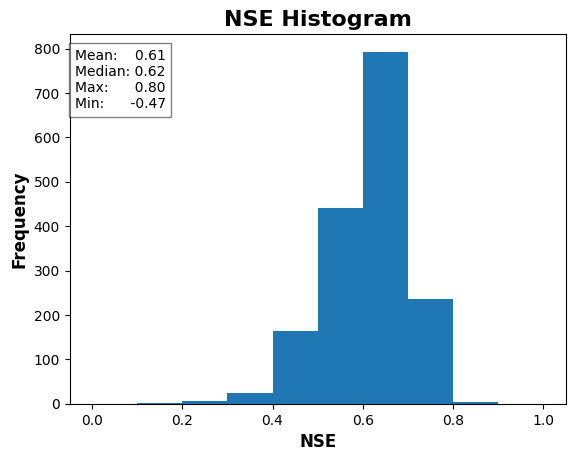

In [13]:
# Plot the histogram
plt.hist(df_NSE['NSE'], bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.2f" % df_NSE["NSE"].mean():>7}\nMedian: {"%.2f" % df_NSE["NSE"].median():>0}\nMax: {"%.2f" % df_NSE["NSE"].max():>9}\nMin: {"%.2f" % df_NSE["NSE"].min():>10}',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel('NSE', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('NSE Histogram', fontsize=16, fontweight='bold')
#plt.savefig(save_folder+'/NSE_LSTM_Histogram.png', bbox_inches='tight', pad_inches=0)
plt.show()

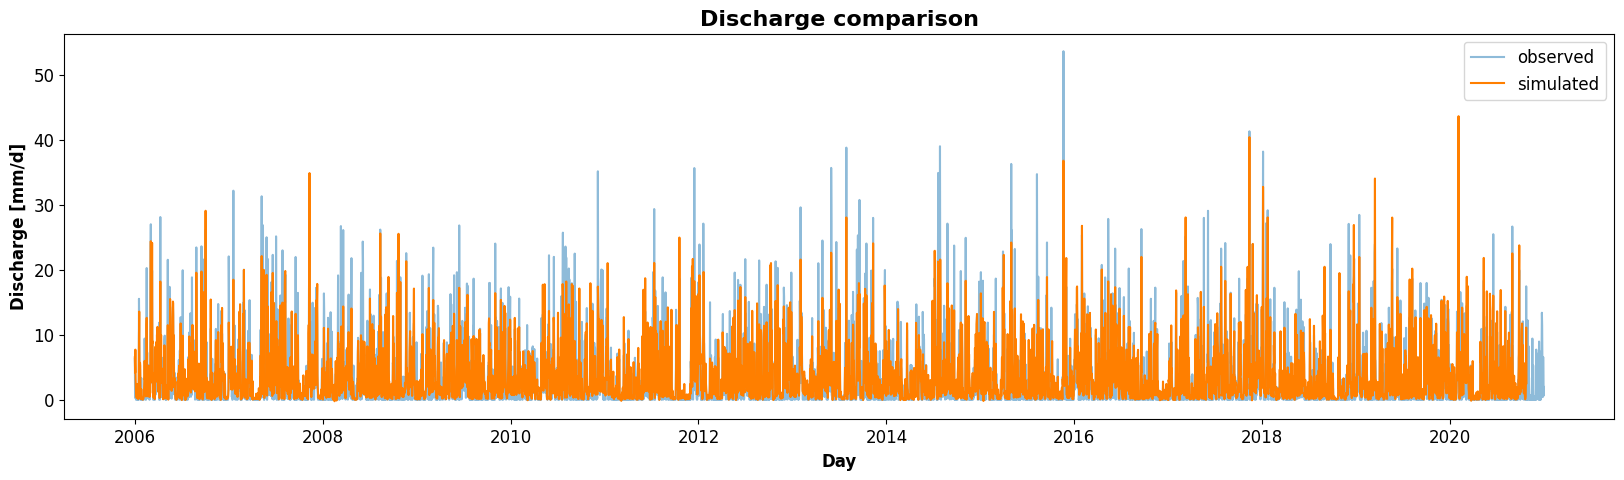

In [14]:
# Plot simulated and observed discharges
basin_to_analyze = 'GRDC_6335125'

plt.plot(y_obs[basin_to_analyze], label="observed", color=color_palette["observed"], alpha=0.5)
plt.plot(y_sim[basin_to_analyze], label="simulated", color=color_palette["LSTM"])

# Format plot
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('Discharge [mm/d]', fontsize=12, fontweight='bold')
plt.title('Discharge comparison', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)
#plt.savefig(save_folder+'/Model_Comparison.png', bbox_inches='tight', pad_inches=0)

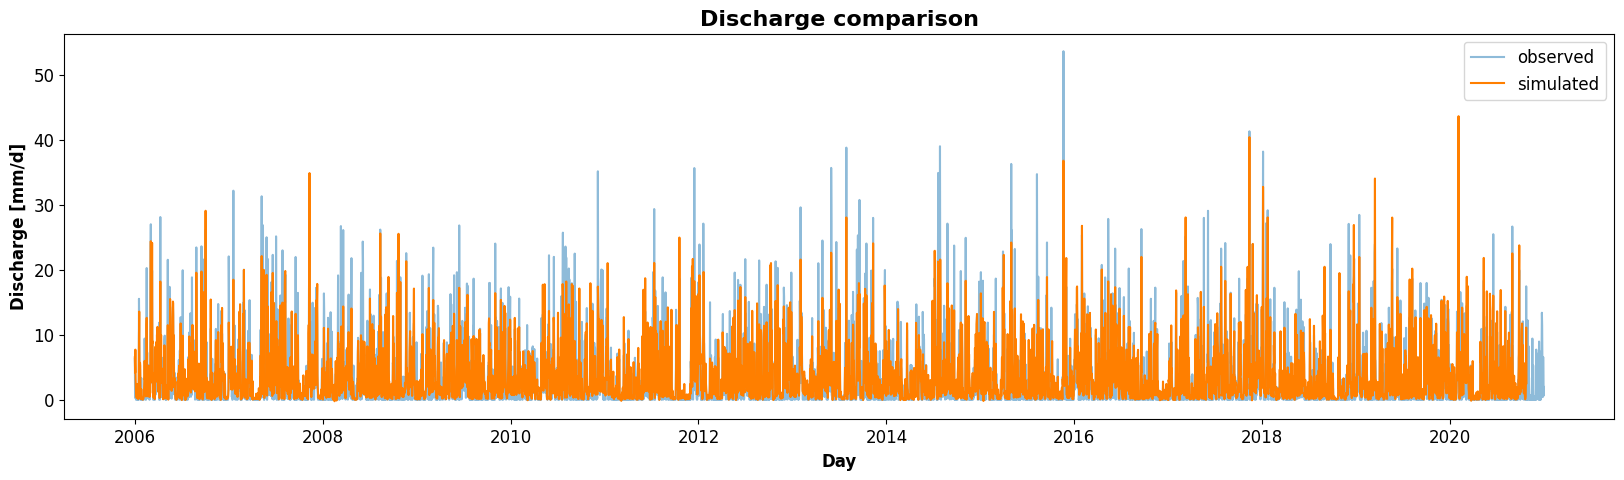

In [15]:
# Plot simulated and observed discharges
basin_to_analyze = 'GRDC_6335125'

plt.plot(y_obs[basin_to_analyze], label="observed", color=color_palette["observed"], alpha=0.5)
plt.plot(y_sim[basin_to_analyze], label="simulated", color=color_palette["LSTM"])

# Format plot
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('Discharge [mm/d]', fontsize=12, fontweight='bold')
plt.title('Discharge comparison', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)
#plt.savefig(save_folder+'/Model_Comparison.png', bbox_inches='tight', pad_inches=0)

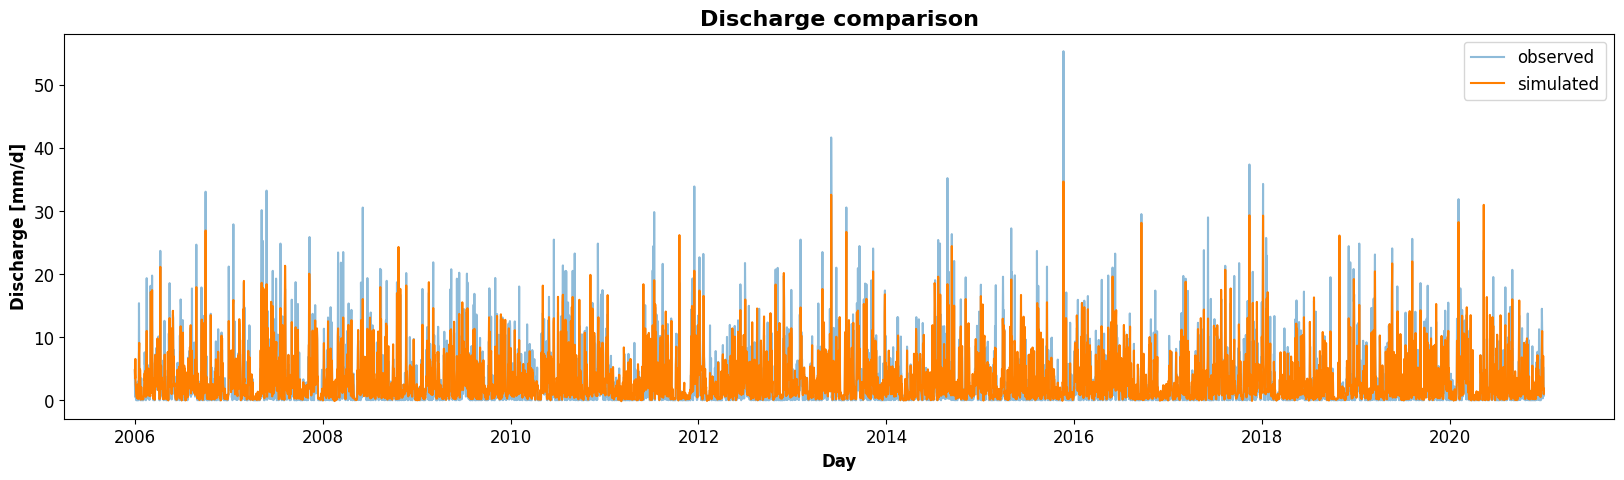

In [16]:
# Plot simulated and observed discharges
basin_to_analyze = 'GRDC_6335660'

plt.plot(y_obs[basin_to_analyze], label="observed", color=color_palette["observed"], alpha=0.5)
plt.plot(y_sim[basin_to_analyze], label="simulated", color=color_palette["LSTM"])

# Format plot
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('Discharge [mm/d]', fontsize=12, fontweight='bold')
plt.title('Discharge comparison', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)
#plt.savefig(save_folder+'/Model_Comparison.png', bbox_inches='tight', pad_inches=0)

In [17]:
lstm_model

DataParallel(
  (module): Cuda_LSTM(
    (lstm): LSTM(9, 64, batch_first=True)
    (dropout): Dropout(p=0.4, inplace=False)
    (linear): Linear(in_features=64, out_features=1, bias=True)
  )
)

Ungauged experiment - Weiherbach and Schwarbach

In [18]:
# Dataset testing
path_entities = '../data/basins_grdc_trial.txt'
testing_period = ['1980-01-01','2020-12-31']
test_dataset = BaseDataset(dynamic_input=dynamic_input,
                           static_input=static_input,
                           target=target,
                           sequence_length=model_hyper_parameters['seq_length'],
                           time_period=testing_period,
                           path_entities=path_entities,
                           path_data=path_data,
                           check_NaN=False)
# We can read a previously stored scaler or use the one from the training dataset we just generated
#scaler = training_dataset.scaler
with open(path_save_folder + "/scaler.pickle", "rb") as file:
    scaler = pickle.load(file)
    
test_dataset.scaler = scaler # read the global statisctics calculated in the training period
test_dataset.standardize_data(standardize_output=False)

# DataLoader for testing data.
test_batches=[[index for index, _ in group] for _ , group in groupby(enumerate(test_dataset.valid_entities), 
                                                                     lambda x: x[1][0])]

test_loader = DataLoader(dataset=test_dataset, batch_sampler=test_batches)

# see if the batches are loaded correctly
print('Batches in testing: ', len(test_loader))
x_lstm, y= next(iter(test_loader))
print(f'x_lstm: {x_lstm.shape} | y: {y.shape}')

# create some lists with the valid basins and the valid entities per basin that will help later to organize the data
valid_basins_testing = [next(group)[0] for key, group in groupby(test_dataset.valid_entities, key=lambda x: x[0])]
valid_entity_per_basin_testing = [[id for _, id in group] for key, group in groupby(test_dataset.valid_entities, 
                                                                                    key=lambda x: x[0])]
lstm_model.eval()
test_results = {}
# Testing----------------------------------------------------------------------
with torch.no_grad():
    for i, (x_lstm, y) in enumerate(test_loader):
        # run LSTM
        y_sim = lstm_model(x_lstm.to(device)) # forward call
        
        # scale back prediction
        y_sim = y_sim* test_dataset.scaler['y_std'].to(device) + test_dataset.scaler['y_mean'].to(device)

        # join results in a dataframe and store them in a dictionary (is easier to plot later)
        df_ts = test_dataset.df_ts[valid_basins_testing[i]].iloc[valid_entity_per_basin_testing[i]]
        df_new = pd.DataFrame(data={'y_obs': y.flatten().cpu().detach().numpy(), 
                                    'y_sim': y_sim.flatten().cpu().detach().numpy()}, index=df_ts.index)
        df_ts = pd.concat([df_ts, df_new], axis=1)
        df_ts = df_ts.filter(['y_obs', 'y_sim'])
        test_results[valid_basins_testing[i]] = df_ts
        
        # remove from cuda
        del x_lstm, y, y_sim
        torch.cuda.empty_cache()

Batches in testing:  4
x_lstm: torch.Size([14976, 365, 9]) | y: torch.Size([14976, 1])


Folder '../results/withdischarge_ungauged' created successfully.


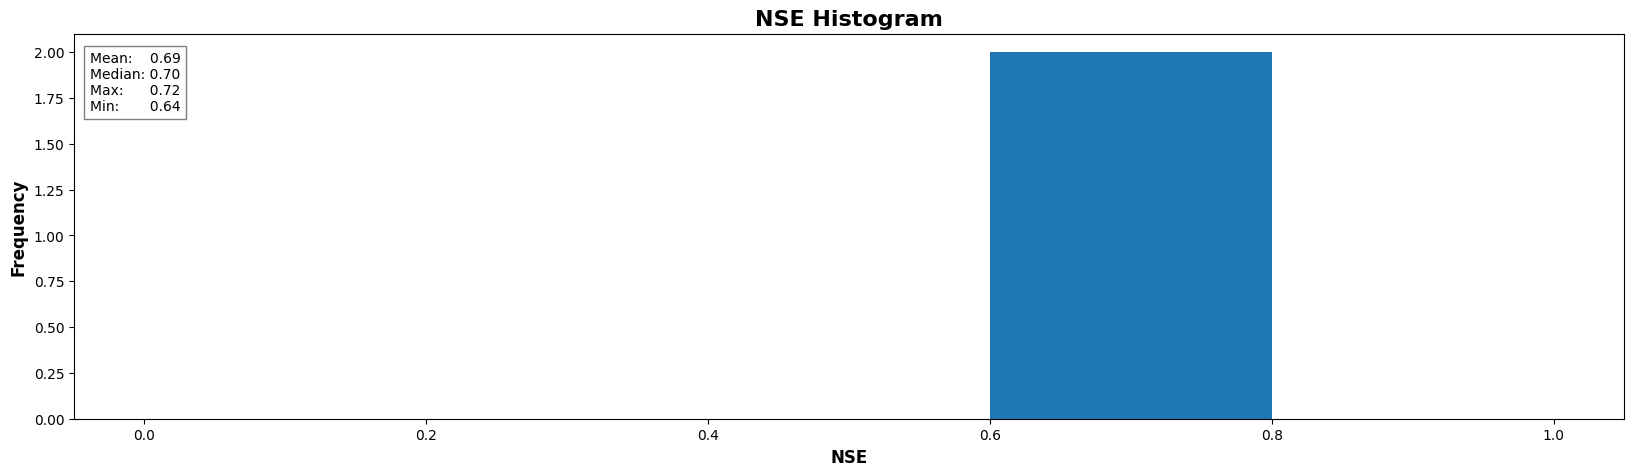

In [19]:
# Loss testing
path_save_folder = '../results/withdischarge_ungauged'
create_folder(folder_path=path_save_folder)
loss_testing = nse(df_results=test_results, average=False)
df_NSE = pd.DataFrame(data={'basin_id': valid_basins_testing, 'NSE': np.round(loss_testing,3)})
df_NSE = df_NSE.set_index('basin_id')
df_NSE.to_csv(path_save_folder+'/NSE.csv', index=True, header=True)

# Simulated and observed results
y_sim = pd.concat([pd.DataFrame({key: value['y_sim']}) for key, value in test_results.items()], axis=1)
y_obs = pd.concat([pd.DataFrame({key: value['y_obs']}) for key, value in test_results.items()], axis=1)

# Set index same as last dataframe in loop (because of how the dataframes where constructed all have the same indexes)
y_sim = y_sim.set_index(list(test_results.values())[0]['y_sim'].index)
y_obs = y_obs.set_index(list(test_results.values())[0]['y_obs'].index)

# Export the results
y_sim.to_csv(path_save_folder+'/y_sim.csv', index=True, header=True)
y_obs.to_csv(path_save_folder+'/y_obs.csv', index=True, header=True)
# Plot the histogram
plt.hist(df_NSE['NSE'], bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.2f" % df_NSE["NSE"].mean():>7}\nMedian: {"%.2f" % df_NSE["NSE"].median():>0}\nMax: {"%.2f" % df_NSE["NSE"].max():>9}\nMin: {"%.2f" % df_NSE["NSE"].min():>10}',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel('NSE', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('NSE Histogram', fontsize=16, fontweight='bold')
#plt.savefig(save_folder+'/NSE_LSTM_Histogram.png', bbox_inches='tight', pad_inches=0)
plt.show()

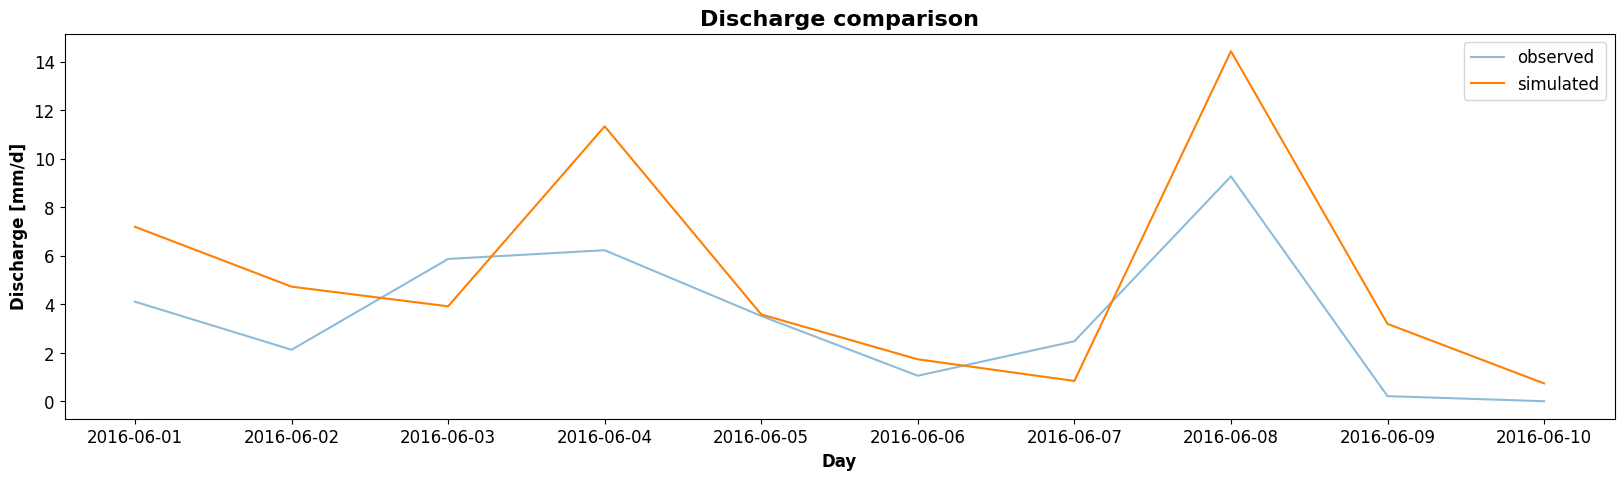

In [20]:
# Specify start and end dates
basin_to_analyze = 'testde_2'
start_date = '2016-06-01'  # Replace with your start date
end_date = '2016-06-10'    # Replace with your end date

# Select data within the specified date range
y_obs_subset = y_obs[basin_to_analyze][start_date:end_date]
y_sim_subset = y_sim[basin_to_analyze][start_date:end_date]

# Plot observed and simulated discharges
plt.plot(y_obs_subset, label="observed", color=color_palette["observed"], alpha=0.5)
plt.plot(y_sim_subset, label="simulated", color=color_palette["LSTM"])

# Format plot
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('Discharge [mm/d]', fontsize=12, fontweight='bold')
plt.title('Discharge comparison', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)

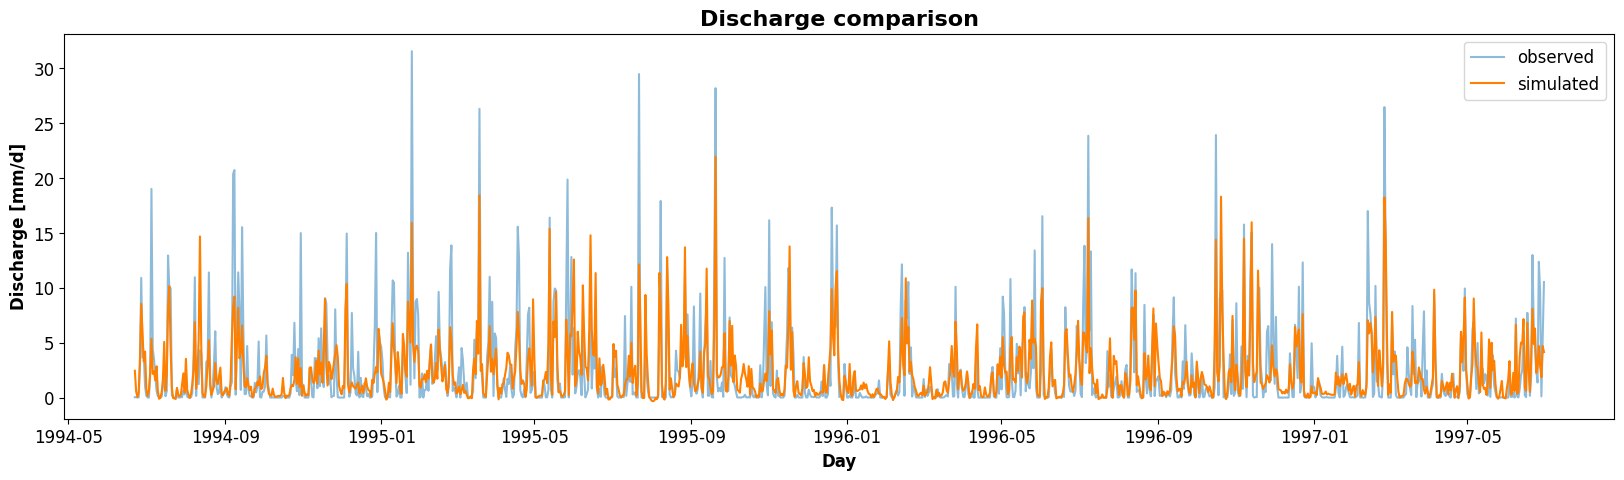

In [24]:
# Specify start and end dates
basin_to_analyze = 'testde_1'
start_date = '1994-06-22'  # Replace with your start date
end_date = '1997-06-30'    # Replace with your end date

# Select data within the specified date range
y_obs_subset = y_obs[basin_to_analyze][start_date:end_date]
y_sim_subset = y_sim[basin_to_analyze][start_date:end_date]

# Plot observed and simulated discharges
plt.plot(y_obs_subset, label="observed", color=color_palette["observed"], alpha=0.5)
plt.plot(y_sim_subset, label="simulated", color=color_palette["LSTM"])

# Format plot
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('Discharge [mm/d]', fontsize=12, fontweight='bold')
plt.title('Discharge comparison', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)

Test for catchments in Spain

In [8]:
# In case I already trained an LSTM I can re-construct the model
lstm_model = Cuda_LSTM(model_hyper_parameters).to(device)
lstm_model = nn.DataParallel(lstm_model)
lstm_model.load_state_dict(torch.load(path_save_folder + '/epoch_5'))

<All keys matched successfully>

In [9]:
# Dataset testing
path_entities = '../data/basins_spain.txt'
testing_period = ['1980-01-01','2020-12-31']
test_dataset = BaseDataset(dynamic_input=dynamic_input,
                           static_input=static_input,
                           target=target,
                           sequence_length=model_hyper_parameters['seq_length'],
                           time_period=testing_period,
                           path_entities=path_entities,
                           path_data=path_data,
                           check_NaN=False)
# We can read a previously stored scaler or use the one from the training dataset we just generated
#scaler = training_dataset.scaler
with open(path_save_folder + "/scaler.pickle", "rb") as file:
    scaler = pickle.load(file)
    
test_dataset.scaler = scaler # read the global statisctics calculated in the training period
test_dataset.standardize_data(standardize_output=False)

# DataLoader for testing data.
test_batches=[[index for index, _ in group] for _ , group in groupby(enumerate(test_dataset.valid_entities), 
                                                                     lambda x: x[1][0])]

test_loader = DataLoader(dataset=test_dataset, batch_sampler=test_batches)

# see if the batches are loaded correctly
print('Batches in testing: ', len(test_loader))
x_lstm, y= next(iter(test_loader))
print(f'x_lstm: {x_lstm.shape} | y: {y.shape}')

# create some lists with the valid basins and the valid entities per basin that will help later to organize the data
valid_basins_testing = [next(group)[0] for key, group in groupby(test_dataset.valid_entities, key=lambda x: x[0])]
valid_entity_per_basin_testing = [[id for _, id in group] for key, group in groupby(test_dataset.valid_entities, 
                                                                                    key=lambda x: x[0])]
lstm_model.eval()
test_results = {}
# Testing----------------------------------------------------------------------
with torch.no_grad():
    for i, (x_lstm, y) in enumerate(test_loader):
        # run LSTM
        y_sim = lstm_model(x_lstm.to(device)) # forward call
        
        # scale back prediction
        y_sim = y_sim* test_dataset.scaler['y_std'].to(device) + test_dataset.scaler['y_mean'].to(device)

        # join results in a dataframe and store them in a dictionary (is easier to plot later)
        df_ts = test_dataset.df_ts[valid_basins_testing[i]].iloc[valid_entity_per_basin_testing[i]]
        df_new = pd.DataFrame(data={'y_obs': y.flatten().cpu().detach().numpy(), 
                                    'y_sim': y_sim.flatten().cpu().detach().numpy()}, index=df_ts.index)
        df_ts = pd.concat([df_ts, df_new], axis=1)
        df_ts = df_ts.filter(['y_obs', 'y_sim'])
        test_results[valid_basins_testing[i]] = df_ts
        
        # remove from cuda
        del x_lstm, y, y_sim
        torch.cuda.empty_cache()

Batches in testing:  269
x_lstm: torch.Size([14976, 365, 9]) | y: torch.Size([14976, 1])


Folder '../results/withdischarge_spain' created successfully.


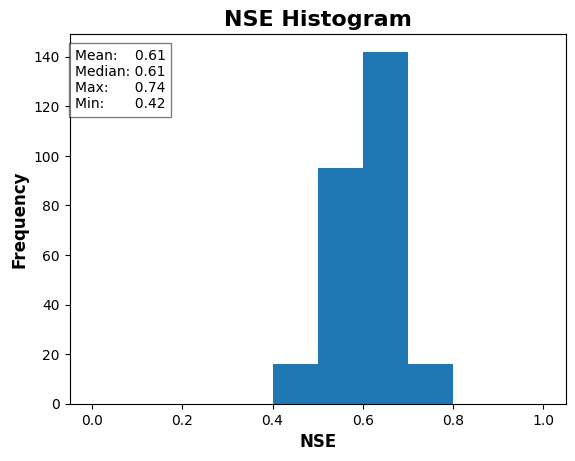

In [10]:
# Loss testing
path_save_folder = '../results/withdischarge_spain'
create_folder(folder_path=path_save_folder)
loss_testing = nse(df_results=test_results, average=False)
df_NSE = pd.DataFrame(data={'basin_id': valid_basins_testing, 'NSE': np.round(loss_testing,3)})
df_NSE = df_NSE.set_index('basin_id')
df_NSE.to_csv(path_save_folder+'/NSE.csv', index=True, header=True)

# Simulated and observed results
y_sim = pd.concat([pd.DataFrame({key: value['y_sim']}) for key, value in test_results.items()], axis=1)
y_obs = pd.concat([pd.DataFrame({key: value['y_obs']}) for key, value in test_results.items()], axis=1)

# Set index same as last dataframe in loop (because of how the dataframes where constructed all have the same indexes)
y_sim = y_sim.set_index(list(test_results.values())[0]['y_sim'].index)
y_obs = y_obs.set_index(list(test_results.values())[0]['y_obs'].index)

# Export the results
y_sim.to_csv(path_save_folder+'/y_sim.csv', index=True, header=True)
y_obs.to_csv(path_save_folder+'/y_obs.csv', index=True, header=True)
# Plot the histogram
plt.hist(df_NSE['NSE'], bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.2f" % df_NSE["NSE"].mean():>7}\nMedian: {"%.2f" % df_NSE["NSE"].median():>0}\nMax: {"%.2f" % df_NSE["NSE"].max():>9}\nMin: {"%.2f" % df_NSE["NSE"].min():>10}',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel('NSE', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('NSE Histogram', fontsize=16, fontweight='bold')
#plt.savefig(save_folder+'/NSE_LSTM_Histogram.png', bbox_inches='tight', pad_inches=0)
plt.show()

Test for camels CH

In [7]:
# In case I already trained an LSTM I can re-construct the model
lstm_model = Cuda_LSTM(model_hyper_parameters).to(device)
lstm_model = nn.DataParallel(lstm_model)
lstm_model.load_state_dict(torch.load(path_save_folder + '/epoch_5'))

<All keys matched successfully>

In [9]:
# Dataset testing
path_entities = '../data/basins_ch.txt'
testing_period = ['1980-01-01','2020-12-31']
test_dataset = BaseDataset(dynamic_input=dynamic_input,
                           static_input=static_input,
                           target=target,
                           sequence_length=model_hyper_parameters['seq_length'],
                           time_period=testing_period,
                           path_entities=path_entities,
                           path_data=path_data,
                           check_NaN=False)
# We can read a previously stored scaler or use the one from the training dataset we just generated
#scaler = training_dataset.scaler
with open(path_save_folder + "/scaler.pickle", "rb") as file:
    scaler = pickle.load(file)
    
test_dataset.scaler = scaler # read the global statisctics calculated in the training period
test_dataset.standardize_data(standardize_output=False)

# DataLoader for testing data.
test_batches=[[index for index, _ in group] for _ , group in groupby(enumerate(test_dataset.valid_entities), 
                                                                     lambda x: x[1][0])]

test_loader = DataLoader(dataset=test_dataset, batch_sampler=test_batches)

# see if the batches are loaded correctly
print('Batches in testing: ', len(test_loader))
x_lstm, y= next(iter(test_loader))
print(f'x_lstm: {x_lstm.shape} | y: {y.shape}')

# create some lists with the valid basins and the valid entities per basin that will help later to organize the data
valid_basins_testing = [next(group)[0] for key, group in groupby(test_dataset.valid_entities, key=lambda x: x[0])]
valid_entity_per_basin_testing = [[id for _, id in group] for key, group in groupby(test_dataset.valid_entities, 
                                                                                    key=lambda x: x[0])]
lstm_model.eval()
test_results = {}
# Testing----------------------------------------------------------------------
with torch.no_grad():
    for i, (x_lstm, y) in enumerate(test_loader):
        # run LSTM
        y_sim = lstm_model(x_lstm.to(device)) # forward call
        
        # scale back prediction
        y_sim = y_sim* test_dataset.scaler['y_std'].to(device) + test_dataset.scaler['y_mean'].to(device)

        # join results in a dataframe and store them in a dictionary (is easier to plot later)
        df_ts = test_dataset.df_ts[valid_basins_testing[i]].iloc[valid_entity_per_basin_testing[i]]
        df_new = pd.DataFrame(data={'y_obs': y.flatten().cpu().detach().numpy(), 
                                    'y_sim': y_sim.flatten().cpu().detach().numpy()}, index=df_ts.index)
        df_ts = pd.concat([df_ts, df_new], axis=1)
        df_ts = df_ts.filter(['y_obs', 'y_sim'])
        test_results[valid_basins_testing[i]] = df_ts
        
        # remove from cuda
        del x_lstm, y, y_sim
        torch.cuda.empty_cache()

Batches in testing:  296
x_lstm: torch.Size([14976, 365, 9]) | y: torch.Size([14976, 1])


Folder '../results/withdischarge_ch' created successfully.


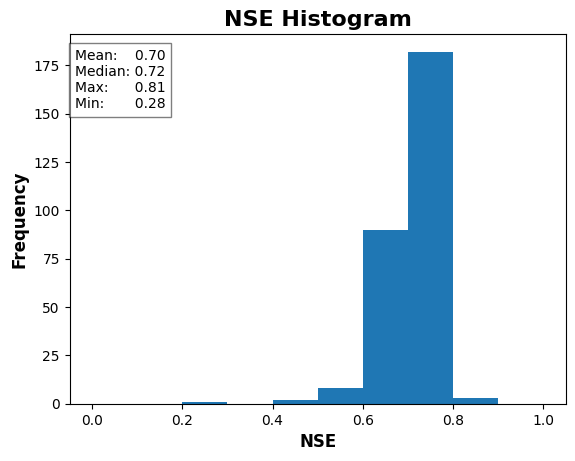

In [10]:
# Loss testing
path_save_folder = '../results/withdischarge_ch'
create_folder(folder_path=path_save_folder)
loss_testing = nse(df_results=test_results, average=False)
df_NSE = pd.DataFrame(data={'basin_id': valid_basins_testing, 'NSE': np.round(loss_testing,3)})
df_NSE = df_NSE.set_index('basin_id')
df_NSE.to_csv(path_save_folder+'/NSE.csv', index=True, header=True)

# Simulated and observed results
y_sim = pd.concat([pd.DataFrame({key: value['y_sim']}) for key, value in test_results.items()], axis=1)
y_obs = pd.concat([pd.DataFrame({key: value['y_obs']}) for key, value in test_results.items()], axis=1)

# Set index same as last dataframe in loop (because of how the dataframes where constructed all have the same indexes)
y_sim = y_sim.set_index(list(test_results.values())[0]['y_sim'].index)
y_obs = y_obs.set_index(list(test_results.values())[0]['y_obs'].index)

# Export the results
y_sim.to_csv(path_save_folder+'/y_sim.csv', index=True, header=True)
y_obs.to_csv(path_save_folder+'/y_obs.csv', index=True, header=True)
# Plot the histogram
plt.hist(df_NSE['NSE'], bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.2f" % df_NSE["NSE"].mean():>7}\nMedian: {"%.2f" % df_NSE["NSE"].median():>0}\nMax: {"%.2f" % df_NSE["NSE"].max():>9}\nMin: {"%.2f" % df_NSE["NSE"].min():>10}',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel('NSE', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('NSE Histogram', fontsize=16, fontweight='bold')
#plt.savefig(save_folder+'/NSE_LSTM_Histogram.png', bbox_inches='tight', pad_inches=0)
plt.show()

Tests for catchment in Luxembourg

In [8]:
# In case I already trained an LSTM I can re-construct the model
lstm_model = Cuda_LSTM(model_hyper_parameters).to(device)
lstm_model = nn.DataParallel(lstm_model)
lstm_model.load_state_dict(torch.load(path_save_folder + '/epoch_5'))

<All keys matched successfully>

In [19]:
# Dataset testing
path_entities = '../data/basins_lux.txt'
testing_period = ['2004-01-01','2020-12-31']
test_dataset = BaseDataset(dynamic_input=dynamic_input,
                           static_input=static_input,
                           target=target,
                           sequence_length=model_hyper_parameters['seq_length'],
                           time_period=testing_period,
                           path_entities=path_entities,
                           path_data=path_data,
                           check_NaN=False) # Change for debugging
# We can read a previously stored scaler or use the one from the training dataset we just generated
#scaler = training_dataset.scaler
path_save_folder = '../results/with_discharge'
with open(path_save_folder + "/scaler.pickle", "rb") as file:
    scaler = pickle.load(file)
    
test_dataset.scaler = scaler # read the global statisctics calculated in the training period
test_dataset.standardize_data(standardize_output=False)

# DataLoader for testing data.
test_batches=[[index for index, _ in group] for _ , group in groupby(enumerate(test_dataset.valid_entities), 
                                                                     lambda x: x[1][0])]

test_loader = DataLoader(dataset=test_dataset, batch_sampler=test_batches)

# see if the batches are loaded correctly
print('Batches in testing: ', len(test_loader))
x_lstm, y= next(iter(test_loader))
print(f'x_lstm: {x_lstm.shape} | y: {y.shape}')

# create some lists with the valid basins and the valid entities per basin that will help later to organize the data
valid_basins_testing = [next(group)[0] for key, group in groupby(test_dataset.valid_entities, key=lambda x: x[0])]
valid_entity_per_basin_testing = [[id for _, id in group] for key, group in groupby(test_dataset.valid_entities, 
                                                                                    key=lambda x: x[0])]
lstm_model.eval()
test_results = {}
# Testing----------------------------------------------------------------------
with torch.no_grad():
    for i, (x_lstm, y) in enumerate(test_loader):
        # run LSTM
        y_sim = lstm_model(x_lstm.to(device)) # forward call
        
        # scale back prediction
        y_sim = y_sim* test_dataset.scaler['y_std'].to(device) + test_dataset.scaler['y_mean'].to(device)

        # join results in a dataframe and store them in a dictionary (is easier to plot later)
        df_ts = test_dataset.df_ts[valid_basins_testing[i]].iloc[valid_entity_per_basin_testing[i]]
        df_new = pd.DataFrame(data={'y_obs': y.flatten().cpu().detach().numpy(), 
                                    'y_sim': y_sim.flatten().cpu().detach().numpy()}, index=df_ts.index)
        df_ts = pd.concat([df_ts, df_new], axis=1)
        df_ts = df_ts.filter(['y_obs', 'y_sim'])
        test_results[valid_basins_testing[i]] = df_ts
        
        # remove from cuda
        del x_lstm, y, y_sim
        torch.cuda.empty_cache()

ValueError: No objects to concatenate

Folder '../results/withdischarge_lx' already exists.


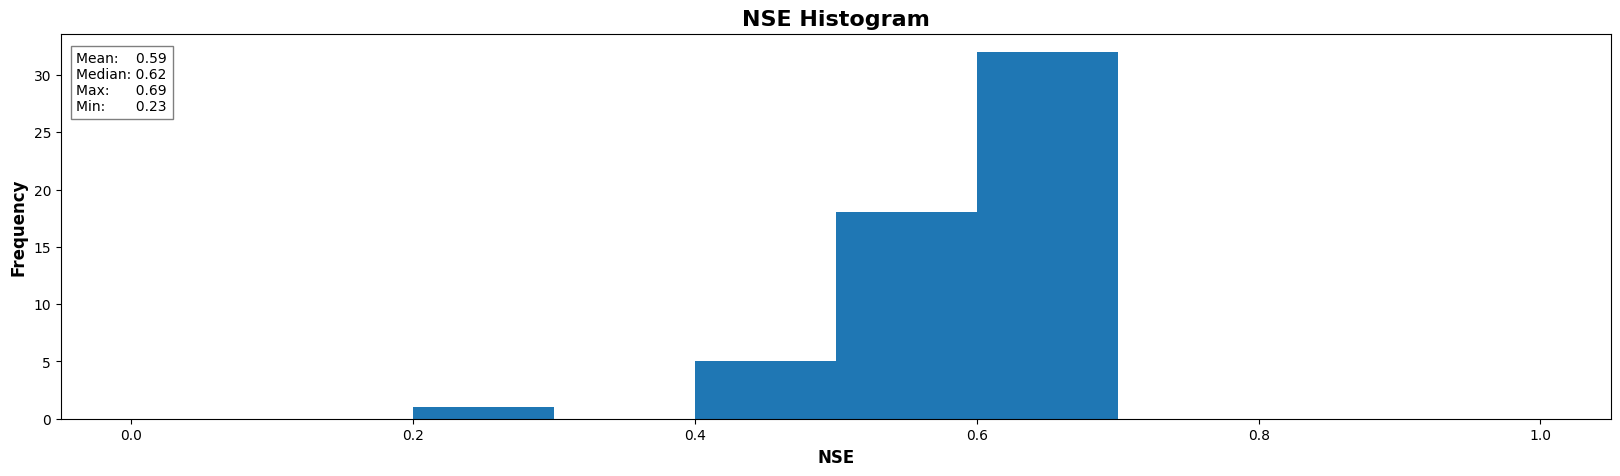

In [28]:
# Loss testing
path_save_folder = '../results/withdischarge_lx'
create_folder(folder_path=path_save_folder)
loss_testing = nse(df_results=test_results, average=False)
df_NSE = pd.DataFrame(data={'basin_id': valid_basins_testing, 'NSE': np.round(loss_testing,3)})
df_NSE = df_NSE.set_index('basin_id')
df_NSE.to_csv(path_save_folder+'/NSE.csv', index=True, header=True)

# Simulated and observed results
y_sim = pd.concat([pd.DataFrame({key: value['y_sim']}) for key, value in test_results.items()], axis=1)
y_obs = pd.concat([pd.DataFrame({key: value['y_obs']}) for key, value in test_results.items()], axis=1)

# Set index same as last dataframe in loop (because of how the dataframes where constructed all have the same indexes)
y_sim = y_sim.set_index(list(test_results.values())[0]['y_sim'].index)
y_obs = y_obs.set_index(list(test_results.values())[0]['y_obs'].index)

# Export the results
y_sim.to_csv(path_save_folder+'/y_sim.csv', index=True, header=True)
y_obs.to_csv(path_save_folder+'/y_obs.csv', index=True, header=True)
# Plot the histogram
plt.hist(df_NSE['NSE'], bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.2f" % df_NSE["NSE"].mean():>7}\nMedian: {"%.2f" % df_NSE["NSE"].median():>0}\nMax: {"%.2f" % df_NSE["NSE"].max():>9}\nMin: {"%.2f" % df_NSE["NSE"].min():>10}',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel('NSE', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('NSE Histogram', fontsize=16, fontweight='bold')
#plt.savefig(save_folder+'/NSE_LSTM_Histogram.png', bbox_inches='tight', pad_inches=0)
plt.show()

Test for catchments in Camels DE

In [8]:
path_save_folder = '../results/with_discharge'
lstm_model = Cuda_LSTM(model_hyper_parameters).to(device)
lstm_model = nn.DataParallel(lstm_model)
lstm_model.load_state_dict(torch.load(path_save_folder + '/epoch_5'))

<All keys matched successfully>

In [9]:
# Dataset testing
path_entities = '../data/basins_camelsde.txt'
testing_period = ['1980-01-01','2020-12-31']
test_dataset = BaseDataset(dynamic_input=dynamic_input,
                           static_input=static_input,
                           target=target,
                           sequence_length=model_hyper_parameters['seq_length'],
                           time_period=testing_period,
                           path_entities=path_entities,
                           path_data=path_data,
                           check_NaN=False) # Change for debugging
# We can read a previously stored scaler or use the one from the training dataset we just generated
#scaler = training_dataset.scaler
path_save_folder = '../results/with_discharge'
with open(path_save_folder + "/scaler.pickle", "rb") as file:
    scaler = pickle.load(file)
    
test_dataset.scaler = scaler # read the global statisctics calculated in the training period
test_dataset.standardize_data(standardize_output=False)

# DataLoader for testing data.
test_batches=[[index for index, _ in group] for _ , group in groupby(enumerate(test_dataset.valid_entities), 
                                                                     lambda x: x[1][0])]

test_loader = DataLoader(dataset=test_dataset, batch_sampler=test_batches)

# see if the batches are loaded correctly
print('Batches in testing: ', len(test_loader))
x_lstm, y= next(iter(test_loader))
print(f'x_lstm: {x_lstm.shape} | y: {y.shape}')

# create some lists with the valid basins and the valid entities per basin that will help later to organize the data
valid_basins_testing = [next(group)[0] for key, group in groupby(test_dataset.valid_entities, key=lambda x: x[0])]
valid_entity_per_basin_testing = [[id for _, id in group] for key, group in groupby(test_dataset.valid_entities, 
                                                                                    key=lambda x: x[0])]
lstm_model.eval()
test_results = {}
# Testing----------------------------------------------------------------------
with torch.no_grad():
    for i, (x_lstm, y) in enumerate(test_loader):
        # run LSTM
        y_sim = lstm_model(x_lstm.to(device)) # forward call
        
        # scale back prediction
        y_sim = y_sim* test_dataset.scaler['y_std'].to(device) + test_dataset.scaler['y_mean'].to(device)

        # join results in a dataframe and store them in a dictionary (is easier to plot later)
        df_ts = test_dataset.df_ts[valid_basins_testing[i]].iloc[valid_entity_per_basin_testing[i]]
        df_new = pd.DataFrame(data={'y_obs': y.flatten().cpu().detach().numpy(), 
                                    'y_sim': y_sim.flatten().cpu().detach().numpy()}, index=df_ts.index)
        df_ts = pd.concat([df_ts, df_new], axis=1)
        df_ts = df_ts.filter(['y_obs', 'y_sim'])
        test_results[valid_basins_testing[i]] = df_ts
        
        # remove from cuda
        del x_lstm, y, y_sim
        torch.cuda.empty_cache()

Batches in testing:  1887
x_lstm: torch.Size([14976, 365, 9]) | y: torch.Size([14976, 1])


Folder '../results/withdischarge_camelsde' created successfully.


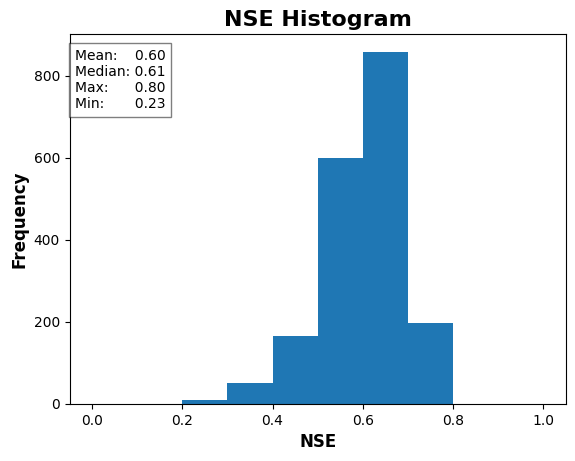

In [10]:
# Loss testing
path_save_folder = '../results/withdischarge_camelsde'
create_folder(folder_path=path_save_folder)
loss_testing = nse(df_results=test_results, average=False)
df_NSE = pd.DataFrame(data={'basin_id': valid_basins_testing, 'NSE': np.round(loss_testing,3)})
df_NSE = df_NSE.set_index('basin_id')
df_NSE.to_csv(path_save_folder+'/NSE.csv', index=True, header=True)

# Simulated and observed results
y_sim = pd.concat([pd.DataFrame({key: value['y_sim']}) for key, value in test_results.items()], axis=1)
y_obs = pd.concat([pd.DataFrame({key: value['y_obs']}) for key, value in test_results.items()], axis=1)

# Set index same as last dataframe in loop (because of how the dataframes where constructed all have the same indexes)
y_sim = y_sim.set_index(list(test_results.values())[0]['y_sim'].index)
y_obs = y_obs.set_index(list(test_results.values())[0]['y_obs'].index)

# Export the results
y_sim.to_csv(path_save_folder+'/y_sim.csv', index=True, header=True)
y_obs.to_csv(path_save_folder+'/y_obs.csv', index=True, header=True)
# Plot the histogram
plt.hist(df_NSE['NSE'], bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.2f" % df_NSE["NSE"].mean():>7}\nMedian: {"%.2f" % df_NSE["NSE"].median():>0}\nMax: {"%.2f" % df_NSE["NSE"].max():>9}\nMin: {"%.2f" % df_NSE["NSE"].min():>10}',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel('NSE', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('NSE Histogram', fontsize=16, fontweight='bold')
#plt.savefig(save_folder+'/NSE_LSTM_Histogram.png', bbox_inches='tight', pad_inches=0)
plt.show()

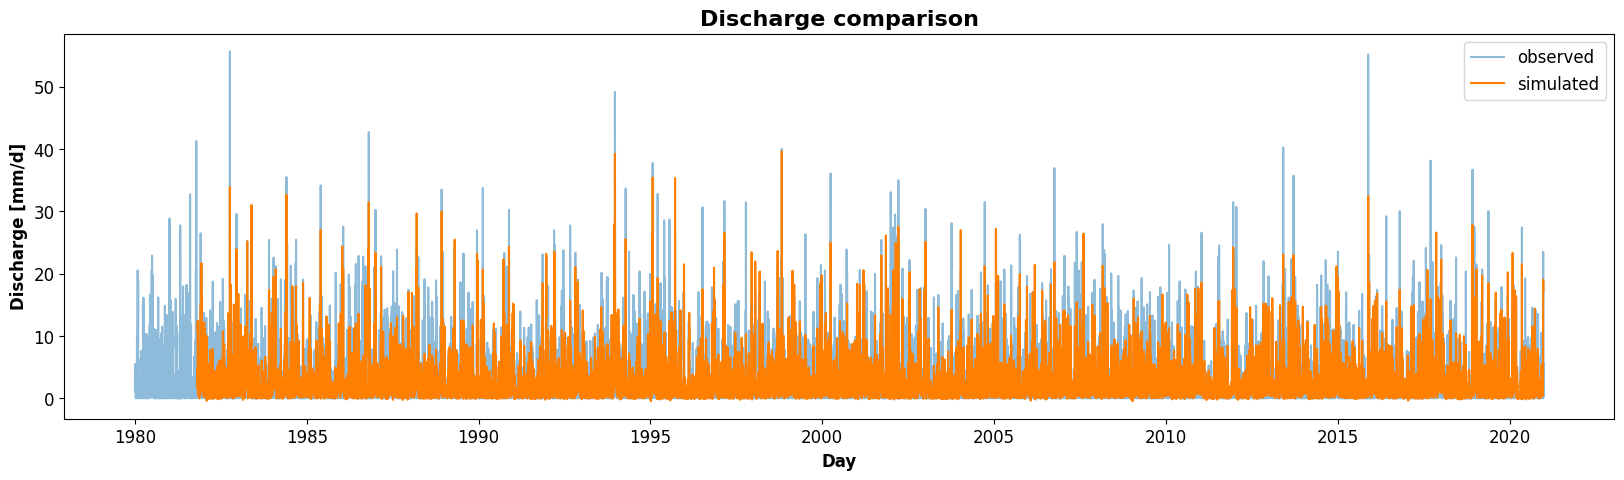

In [11]:
# Plot simulated and observed discharges
basin_to_analyze = 'camelsde_DE111700'

plt.plot(y_obs[basin_to_analyze], label="observed", color=color_palette["observed"], alpha=0.5)
plt.plot(y_sim[basin_to_analyze], label="simulated", color=color_palette["LSTM"])

# Format plot
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('Discharge [mm/d]', fontsize=12, fontweight='bold')
plt.title('Discharge comparison', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)
#plt.savefig(save_folder+'/Model_Comparison.png', bbox_inches='tight', pad_inches=0)